<h1><center>Evaluation apprentissage par renforcement</center></h1>
<h3><center>Groupe : Aymen BOUHOU - Mohammed Zineddine BOUCHERIR - El Mehdi BECHNIKHA<h3><center>

Le problème de Maze est un défi pour les agents d'apprentissage automatique, qui doivent apprendre à naviguer efficacement dans un labyrinthe complexe tout en évitant les obstacles et en atteignant un objectif. Dans ce cas, l'objectif est de parvenir à l'état G ou à l'état F. L'agent d'apprentissage automatique doit utiliser les informations sur son environnement pour planifier ses actions de manière à maximiser sa récompense. Lorsqu'il parvient à l'état G, il reçoit une récompense de 400, et lorsqu'il parvient à l'état F, il reçoit une récompense de 1000. Ce problème nécessite des compétences telles que la planification, la prise de décision, la résolution de problèmes et l'apprentissage par renforcement pour résoudre efficacement. Les agents d'apprentissage automatique doivent être capables d'explorer efficacement l'espace d'état pour découvrir des actions qui mènent à l'objectif final tout en évitant les obstacles. Ils doivent également être capables de s'adapter à des situations imprévues et de maximiser leur récompense dans un environnement incertain. \ 
Pour résoudre ce problème, nous utilisons des algorithmes d'apprentissage par renforcement tels que Monte Carlo, Q-learning ou SARSA. Les choix clés dans l'application de ces algorithmes comprennent la définition des états, des actions et des récompenses de l'agent, ainsi que la sélection des paramètres de l'algorithme.

### Importation des bibliotheques

In [1]:
import base
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import warnings
warnings.filterwarnings("ignore")

### Execice 1 - Prédiction 

##### Question 1

Implémentation de l'algorithme de prédiction Monte-Carlo (MC)

In [2]:
def MC(pi,env, nb_episode=100, gamma=0.5, na=4):

    nbr_state = env.get_nb_states()
    S = np.zeros(nbr_state)
    V = np.zeros(nbr_state)
    n = np.zeros(nbr_state)

    for i in range(nb_episode):
        final = False
        s = env.reset()
        episode = []
    
        while not final:
            a = np.random.choice(na, p=pi[s])
            ns, r, final, _ = env.step(a)
            episode.append([s, a, r, ns])
            s = ns

        g = 0
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s] += 1
            S[s] += g
            V[s] = S[s] / n[s]
    
    return V    

Implémentation de l'algorithme de prédiction Temporal-Difference (TD0)

In [3]:
def TD0(pi,env, nb_episode=100 , alpha=0.1, gamma=0.5, na=4):
    
    nbr_state = env.get_nb_states()
    V = np.zeros(nbr_state)
    
    for i in range(nb_episode):
        final = False
        s = env.reset()
        
        while not final:
            a = np.random.choice(na, p=pi[s])
            ns, r, final, _ = env.step(a)
            V[s] += alpha*(r+gamma*V[ns]-V[s])
            s = ns
    
    return V 

##### Question 2

Comparaison entre MC et TD(0) à partir du calcul de l'erreur de prédiction par une distance euclidienne entre les vecteurs de valeurs calculés et le vecteur de valeurs produit par IPE

Implémentation de l'algorithme de prediction IPE qui servira comme algo de base pour la camparaison entre MC et TD0 

In [4]:
def calculer_q(env, v, gamma=0.5):
    return np.sum(env.p() * (env.r() + gamma*v[np.newaxis, np.newaxis, :]), axis=2)

def ipe(pi, env, gamma=0.5, epsilon=0.01):
    nbr_state = env.get_nb_states()

    v = np.zeros((nbr_state))
    q = calculer_q(env, v, gamma)
    nv = np.sum(pi * q, axis=1)
    
    delta = np.sum(np.abs(nv - v))
    while delta > epsilon:
        v = nv
        q = calculer_q(env, v, gamma)
        nv = np.sum(pi * q, axis=1)
        delta = np.sum(np.abs(nv - v))
    
    return nv

Définition de l'environnement :  
- Environnement de type Maze ;
- Appliquons la politique pi = " Dans chaque état appliquer les probabilités d'actions {W: 0.1, S:0.4, E:0.4, N:0.1} "

In [5]:
env = base.Maze()
nbr_state = env.get_nb_states()
na = env.get_nb_actions()
pi = np.array([[0.1, 0.4, 0.4, 0.1]]*nbr_state)

Les valeurs d'état de l'algorithme MC suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [6]:
MC(pi,env)

array([ 15.80394473,  53.4701101 , 182.11804696,   0.        ,
         3.60293124,   0.        ,  46.49110657,   0.        ,
         8.37671478,  37.69410614, 132.98493036,   0.        ,
         0.62695395,   0.        , 548.01057514,   0.        ])

Les valeurs d'état de l'algorithme TD0 suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [7]:
TD0(pi,env)

array([ 16.04455868,  80.7367694 , 194.49133913,   0.        ,
         4.69811886,   0.        ,  53.93767905,   0.        ,
        14.88496282,  43.91559908, 160.61093492,   0.        ,
         1.08746895,   0.        , 526.6414976 ,   0.        ])

Les valeurs d'état de l'algorithme IPE suivant la politique pi, dans l'environnement Maze, apres 100 nombre d'episodes, de gamma 0.5 et de nombre d'actions 4, sont :

In [8]:
ipe(pi,env)

array([ 11.59279286,  49.16764138, 181.48179409,   0.        ,
         3.00185758,   0.        ,  49.74737104,   0.        ,
         8.36084783,  38.20592509, 141.18327338,   0.        ,
         0.75939102,   0.        , 542.745494  ,   0.        ])

Calcul des erreurs de prédiction par une distance euclidienne entre MC/TD0 et IPE en fonction du nombre d'épisodes, on prend l'intervalle [1,2000] avec le pas de 50

In [9]:
MC_errors=[np.linalg.norm(MC(pi,env,nb_episode) - ipe(pi,env)) for nb_episode in range(1,2000,50)]

In [10]:
TD0_errors=[np.linalg.norm(TD0(pi,env,nb_episode) - ipe(pi,env)) for nb_episode in range(1,2000,50)]

Représentation graphique de l'évolution de l'erreur en fonction du nombre 
d'épisodes effectués

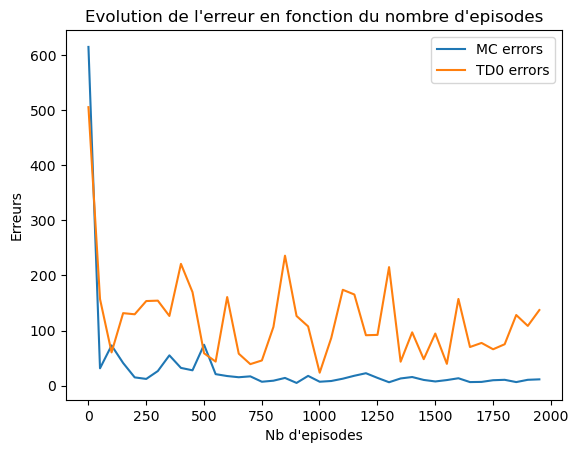

In [11]:
MC_errors = np.array(MC_errors)
TD0_errors = np.array(TD0_errors)

fig, ax = plt.subplots()

ax.plot(range(1,2000,50),MC_errors, label='MC errors')
ax.plot(range(1,2000,50),TD0_errors, label='TD0 errors')

ax.set(xlabel="Nb d'episodes", ylabel='Erreurs', title="Evolution de l'erreur en fonction du nombre d'episodes")
ax.legend()

plt.show()

On constate que l'algorithme MC a convergé rapidement alors que la distance entre l'algorithme TD0 et ipe  osctille entre 50 et 200. Cela s'explique par le fait que MC est efficace avec de petites valeurs et trouve rapidement les bonnes valeurs.

### Execice 2 - Contrôle 

Implémentation de la methode E-greedy

In [12]:
def egreedy(q, s, nb_episode, epsilon, D):
    
    if nb_episode <= D:
        ep = epsilon
    else:
        ep = epsilon / math.sqrt(nb_episode - D)
    
    if np.random.rand()<ep:     
        return np.random.randint(0, q.shape[1])
    else:
        return np.argmax(q[s])

Implémentation de la methode Softmax

In [13]:
def softmax(q, s, nb_episode, T0, D):
    
    if nb_episode <= D:
        T = T0
    else:
        T = T0 / math.sqrt(nb_episode - D)
        
    exp_val = [math.exp(i / T) for i in q[s]]
    softmax_values = [i / np.sum(exp_val) for i in exp_val]
    return random.choices(range(len(q[s])), np.divide(softmax_values, np.sum(softmax_values)), k=1)[0]

Implémentation de la methode Greedy-optimiste

In [14]:
def greedy(q, s):
    return np.argmax(q[s])

Pour simplifier l'excution des algorithmes avec les différentes méthodes de gestion du dilemme Exploration-Exploitation, nous avons ajouter un argement nomme "methode" pour chaque algorithme, cet argument permet de specifier le methode utilise pour l'Exploration-Exploitation, on lui donne par defaut la methode "egreedy".

Implémentation de l'algorithme de contrôle Monte-Carlo-GLIE (MC)

In [15]:
def MC_control(env, gamma = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy"):
    
    na = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), na))
    n = np.zeros((env.get_nb_states(), na))
    
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    pi = np.ones((env.get_nb_states(), na)) / na
    
    for k in range(1, nb_ep_limit+1):
        
        s = env.reset()
        episode = []
        
        while not env.is_final(s):
            a = np.random.choice(na, p = [0.25,0.25,0.25,0.25]) 
            ns, r, _, _ = env.step(a)
            episode.append([s, a, ns, r])
            s = ns
        
        retour = 0
        
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            n[s, a] += 1
            q[s, a] += 1/n[s, a]*(retour - q[s, a])
        
        epsilon = 1 / k
        
        if methode == "egreedy":
            pi = egreedy(q, s, len(episode), epsilon, D)
        
        elif methode == "softmax":
            pi = softmax(q, s, len(episode), T0, D)
        
        else:
            print("Méthode non reconnue")
            sys.exit()
        
        pi = egreedy(q, s, len(episode), epsilon, D) 
        gain[k-1] = retour
        nbs[k-1] = len(episode)
        
    return gain

Implémentation de l'algorithme de contrôle Q-learning (QL)

In [16]:
def Ql(env, gamma = 0.1, alpha = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy", Rmax=1000):
    
    na = env.get_nb_actions()   
    
    if (methode == "greedy optimist"):
        q = np.full((env.get_nb_states(), na), Rmax/(1-gamma))
    else:
        q = np.zeros((env.get_nb_states(), na))
    
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    for k in range(1, nb_ep_limit+1):      
        
        s = env.reset()
        while not env.is_final(s):
            
            if methode == "egreedy":
                a = egreedy(q, s, k, epsilon, D)
            elif methode == "softmax":
                a = softmax(q, s, k, T0, D)
            elif methode == "greedy optimist":
                a = greedy(q,s)
            else:
                print("Méthode non reconnue")
                sys.exit()
            
            ns, r, final, _ = env.step(a)
            
            if final:
            
                target = r
            else:
                target = r + gamma * np.max(q[ns])
            
            gain[k-1] += r
            nbs[k-1] += 1
            q[s, a] += alpha * (target - q[s, a])
            s = ns
    
    return gain

Implémentation de l'algorithme de contrôle Sarsa

In [17]:
def Sarsa(env, gamma = 0.9, alpha = 0.5, epsilon = 0.5, T0 = 100, nb_ep_limit = 1000, D = 4000, methode = "egreedy",Rmax=1000):
    
    na = env.get_nb_actions()
    
    if (methode == "greedy optimist"):
        q = np.full((env.get_nb_states(), na), Rmax/(1-gamma))
    else:
        q = np.zeros((env.get_nb_states(), na))
        
    gain = np.zeros(nb_ep_limit)
    nbs = np.zeros(nb_ep_limit)
    
    for k in range(1, nb_ep_limit+1):      
        
        s = env.reset()
        
        if methode == "egreedy":
            a = egreedy(q, s, k, epsilon, D)
        elif methode == "softmax":
            a = softmax(q, s, k, T0, D)
        elif methode == "greedy optimist":
            a = greedy(q,s)
        else:
            print("Méthode non reconnue")
            sys.exit()
            
        while not env.is_final(s):
            
            ns, r, final, _ = env.step(a)
            
            if methode == "egreedy":
                na = egreedy(q, ns, k, epsilon, D)
            elif methode == "softmax":
                na = softmax(q, ns, k, T0, D)
            elif methode == "greedy optimist":
                na = greedy(q,ns)
            else:
                print("Méthode non reconnue")
                sys.exit()

            if final:
                
                target = r
            else:
                target = r + gamma * q[ns,na]
                
            gain[k-1] += r
            nbs[k-1] += 1
            q[s, a] += alpha * (target - q[s, a])
            s = ns
            a=na
    
    return gain

Fonction Visualiser qui retourne un graphique des gains pour des paramètres fixés

<AxesSubplot: >

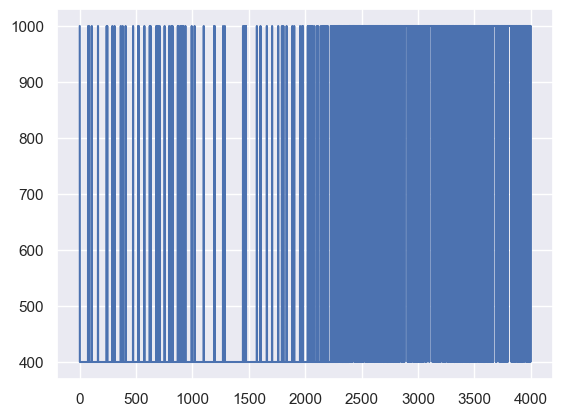

In [18]:
def Visualiser(algo, env, gamma = 0.9, alpha = 0.1, epsilon=0.5, nb_ep_limit = 5000, D=4000):
    liste=algo(env, gamma, alpha, epsilon, nb_ep_limit, D)
    sns.set_theme(style="darkgrid")
    return sns.lineplot(liste)

Visualiser(Sarsa, env)

Le problème du graphique est qu'il contient un grand nombre d'épisodes, ce qui rend très difficile leur visualisation. Nous envisageons donc de prendre la moyenne de chaque groupe de 20 épisodes (reshape(-1,20).mean(axis=1)), pour reprendre le graphique et mieux visualiser.

Fonction Visualiser_moy qui retourne un graphique des moyennes des gains pour des paramètres fixés

In [19]:
def Visualiser_moy(algo, env, gamma, alpha, epsilon,T0 = 100,nb_ep_limit = 5000, D = 4000, methode = "egreedy",Rmax=1000):
    
    if (algo == MC_control):
        result = np.empty((len(gamma), len(epsilon),500))
        for i,gam in enumerate(gamma):
            for k,ep in enumerate(epsilon):
                result[i][k]=algo(env,gam,ep,T0,nb_ep_limit, D, methode).reshape(-1,10).mean(axis=1)
                sns.set_theme(style="darkgrid")
                sns.lineplot(result[i][k],label=f"gamma={gam}, epsilon={ep}, methode={methode}", linewidth=2)
                sns.despine()
                plt.legend(bbox_to_anchor=(0.7,0.5), loc=2, borderaxespad=0.,)
    else:    
        result = np.empty((len(gamma), len(alpha), len(epsilon),500))
        for i,gam in enumerate(gamma):
            for j,alp in enumerate(alpha):
                for k,ep in enumerate(epsilon):
                    result[i][j][k]=algo(env,gam,alp,ep,T0,nb_ep_limit, D, methode,Rmax).reshape(-1,10).mean(axis=1)
                    sns.set_theme(style="darkgrid")
                    sns.lineplot(result[i][j][k],label=f"gamma={gam}, alpha={alp}, epsilon={ep}, methode={methode}", linewidth=2)
                    sns.despine()
                    plt.legend(bbox_to_anchor=(0.7,0.5), loc=2, borderaxespad=0.,)

#### Visualisation des algorithmes

On note que
* Le paramètre alpha est utilisé pour déterminer la proportion de la nouvelle information à utiliser pour mettre à jour les valeurs q. Il est utilisé pour pondérer l'importance de la nouvelle information par rapport à l'ancienne. Plus alpha est élevé, plus la nouvelle information est prise en compte pour mettre à jour les valeurs q
* Le paramètre gamma est utilisé pour déterminer l'importance de la récompense future par rapport à la récompense immédiate.
* Le paramètre epsilon est utilisé pour introduire une certaine incertitude dans la prise de décision, on le fixe a 0.5 pour introduire un peu d'incertitude

Visualisation de l'algorithme de contrôle Q-learning avec différents paramètres

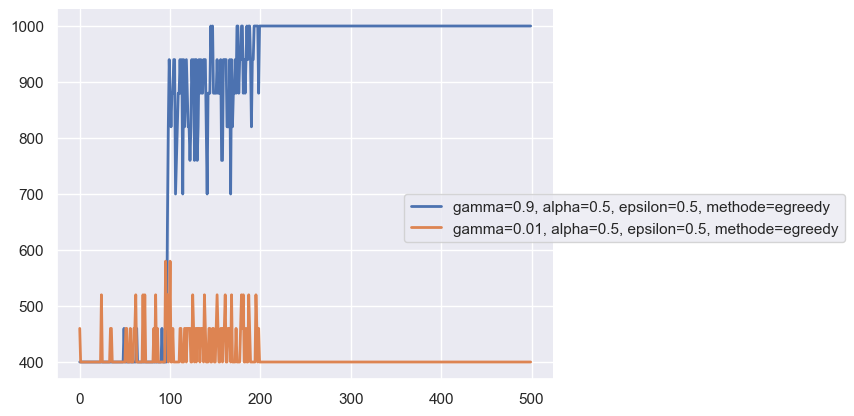

In [20]:
Visualiser_moy(Ql, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=2000 , methode = "egreedy")

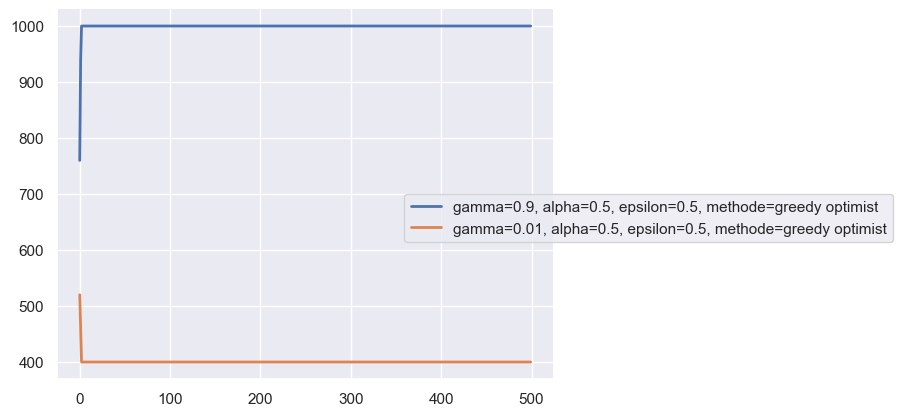

In [21]:
Visualiser_moy(Ql, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=2000 , methode = "greedy optimist")

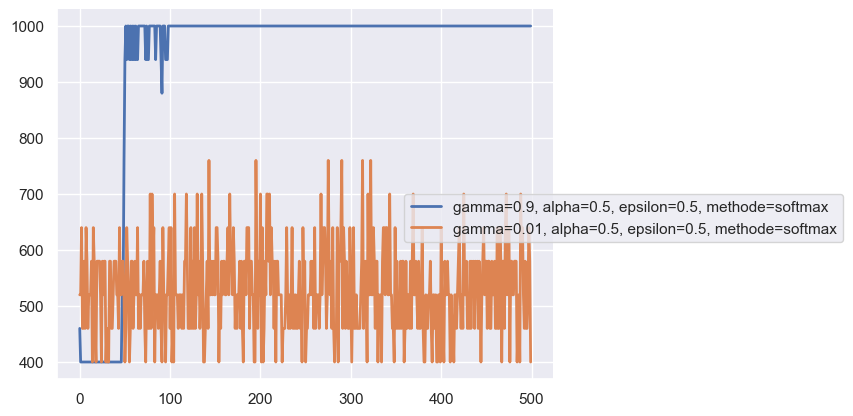

In [22]:
Visualiser_moy(Ql, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=1000 , methode = "softmax")

* Si gamma est proche de 0 l'algo converge vers 400 le plus petit gain, Si gamma est proche de 1, l'algo tend vers le plus grand gain 1000.
* La methode "greedy optimist" converge rapidement car initialise avec le gain maximale.
* La methode "softmax" ostille et ne converge pas pour un gamma tres petit, mais il converge pour un gamma proche de 1.

Visualisation de l'algorithme de contrôle Sarsa avec différents paramètres

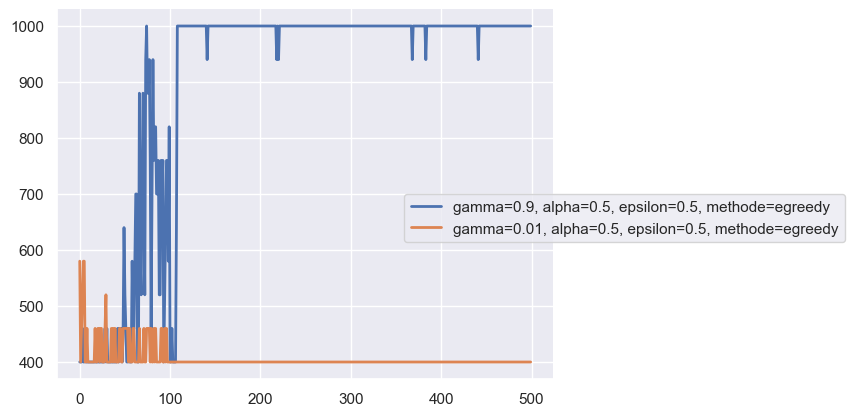

In [23]:
Visualiser_moy(Sarsa, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=1000 , methode = "egreedy")

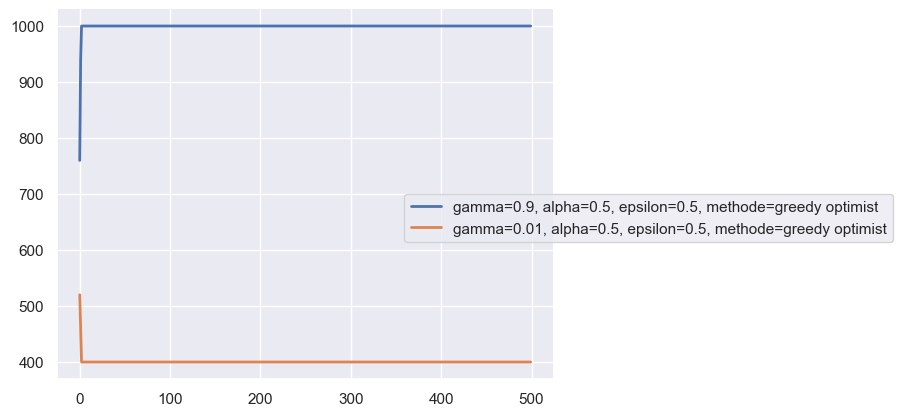

In [24]:
Visualiser_moy(Sarsa, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=1000 , methode = "greedy optimist")

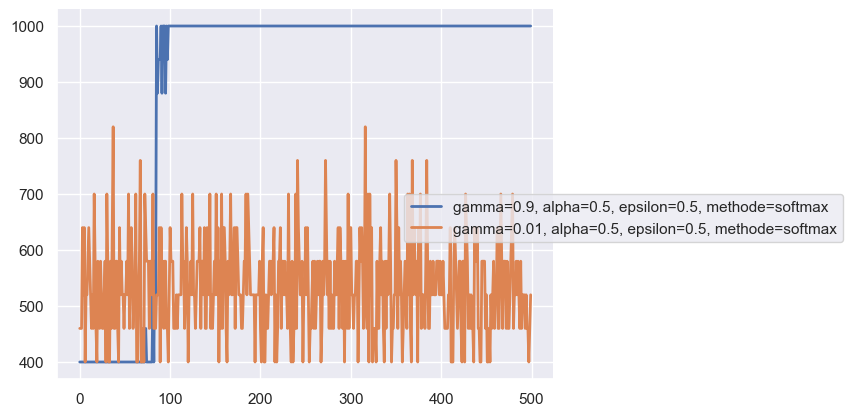

In [25]:
Visualiser_moy(Sarsa, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=1000 , methode = "softmax")

* Si gamma est proche de 0 l'algo converge vers 400 le plus petit gain, Si gamma est proche de 1, l'algo tend vers le plus grand gain 1000.
* La methode "greedy optimist" converge rapidement car initialise avec le gain maximale.
* La methode "softmax" ostille et ne converge pas pour un gamma tres petit, mais il converge pour un gamma proche de 1.
* En moyenne Sarsa converge plus rapidement que Ql pour "egreedy"
* Le meme probleme en "softmax" pour Sarsa et Ql

Visualisation de l'algorithme de contrôle Monte-Carlo-GLIE avec différents paramètres

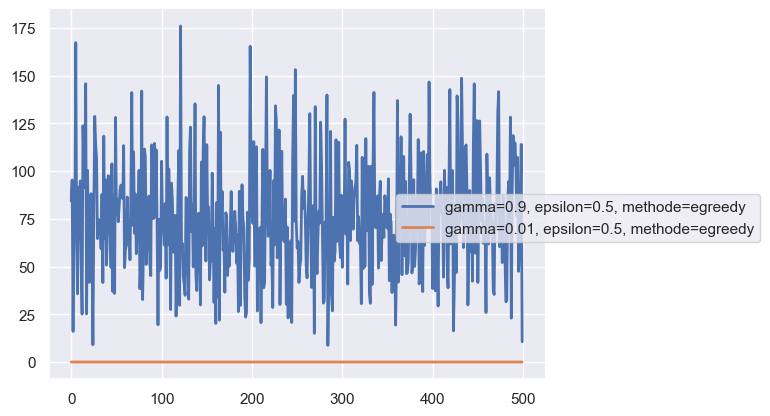

In [26]:
Visualiser_moy(MC_control, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=2000 , methode = "egreedy")

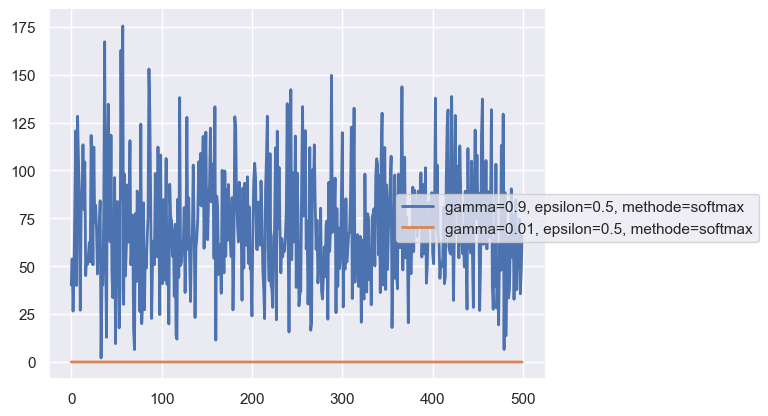

In [27]:
Visualiser_moy(MC_control, env,gamma=[0.9,0.01],alpha=[0.5],epsilon=[0.5], nb_ep_limit = 5000, D=2000 , methode = "softmax")

* Meme si gama est proche de 1 MC ne converge, mais il reste a 0 pour un gamma tres petit
* Meme si la methode d'exploration change on obtient pas la convergence pour MC